# Классификация Симпсонов

<center><img src='https://www.film.ru/sites/default/files/filefield_paths/the-simpsons-tv-series-cast-wallpaper-109911.0.0.jpeg'  width="800" height="400"></center>

In [1]:
!pip install vision_transformer_pytorch 
!pip install Pillow
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=759e68100ceabdbb3030f883f4763fb56356a4e623f01d57ab6ea7a3a82a715e
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [2]:
import os
import time
import copy
import tarfile
from shutil import rmtree
from tqdm.notebook import tqdm
from random import choice
from pathlib import Path
from PIL import Image

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

import torch
import torchvision
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_url
from torchvision import models, transforms

# Killer feature
from vision_transformer_pytorch import VisionTransformer
from efficientnet_pytorch import EfficientNet

from warnings import filterwarnings
filterwarnings('ignore', module="matplotlib\..*")

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.8.1+cu101
Torchvision Version:  0.9.1+cu101


In [3]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


# Загрузка и обработка данных

Архив с соответствующими данными сперва должен быть скачен с kaggle на google drive в корневую директорию, иначе код ниже не имеет смысла... (Ой, а еще бы хорошо, все это на Колабе запускать)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [14]:
TRAIN_DIR = Path("train/simpsons_dataset")
TEST_DIR  = Path("testset/testset")
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224

In [15]:
train_val_files = list(TRAIN_DIR.rglob('*.jpg'))
test_files = list(TEST_DIR.rglob('*.jpg'))

## Написание своего Dataset

In [16]:
class NonExistentMode(Exception):
    def __init__(self):
        super().__init__(self)


class SimpsonsDataset(Dataset):
    def __init__(self, files, mode, transform):
        self.transform = transform
        self.files = sorted(files)
        
        if mode in DATA_MODES:
            self.mode = mode
        else:
            raise NonExistentMode

        self.size = len(files)
        self.encoder = LabelEncoder()

        if self.mode != 'test':
            encoder = LabelEncoder()
            self.labels = [path.parent.name for path in self.files]
            self.encoder.fit(self.labels)

    def __len__(self):
        return self.size

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        x = self.load_sample(self.files[index])
        x = np.array(np.array(x) / 255, dtype='float32')
        
        x = self.transform(x)

        if self.mode == 'test':
            return x

        else:
            label = self.labels[index]
            label_id = self.encoder.transform([label])
            y = label_id.item()

            return x, y

    def transform(self, name):
        return self.encoder.transform(name)

    def inverse_transform(self, class_number):
        return self.encoder.inverse_transform(class_number)

    def get_character_name(self, index):
        return self.labels[index]

In [17]:
train_files, val_files = train_test_split(train_val_files, test_size = 0.3, shuffle=True,
                                          stratify=[path.parent.name for path in train_val_files])

## Аугментация данных

In [18]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(RESCALE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=np.random.randint(low=0, high=41)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(RESCALE_SIZE),
    transforms.CenterCrop(RESCALE_SIZE), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

In [19]:
train_dataset = SimpsonsDataset(train_files, mode='train', transform=train_transform)
val_dataset = SimpsonsDataset(val_files, mode='val', transform=val_test_transform)
test_dataset = SimpsonsDataset(test_files, mode='test', transform=val_test_transform)

In [20]:
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

learning_dataloaders = {'train': train_dataloader, 'val': val_dataloader}

## Визуализация пары объектов

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


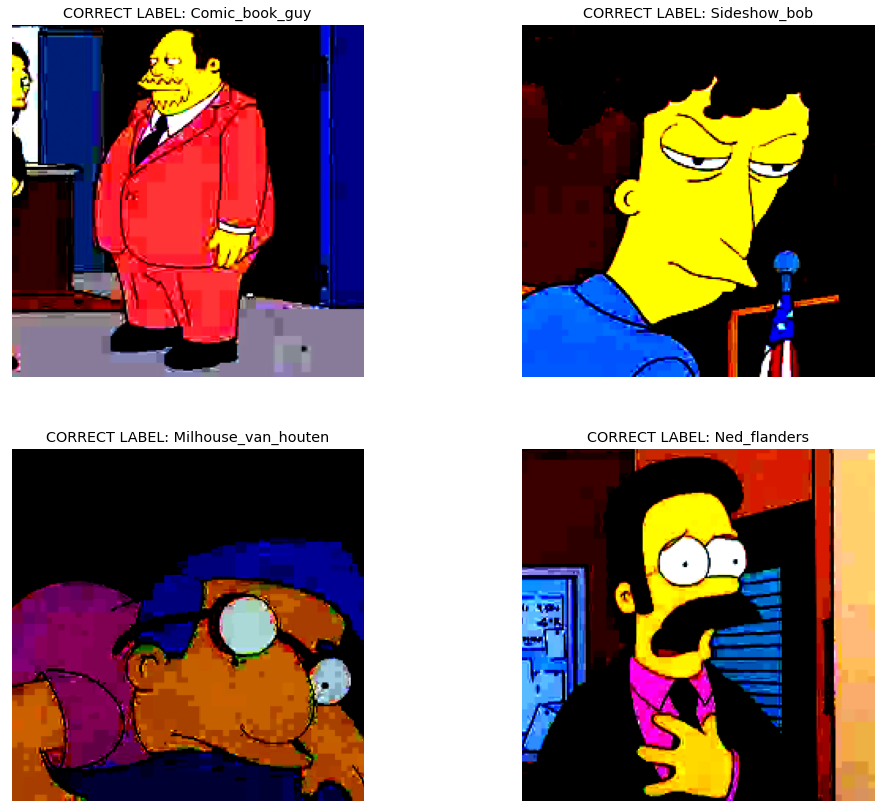

In [21]:
NUM = 2
fig, ax = plt.subplots(NUM, NUM, figsize=(10, 10))
plt.subplots_adjust(left=NUM*(-0.2), bottom=NUM*(-0.1))

for i in range(NUM**2):
    idx = np.random.randint(low=0, high=len(val_dataset))
    image, _ = val_dataset[idx]
    label = val_dataset.get_character_name(idx)
    
    ax[i // NUM, i % NUM].imshow(image.permute(1, 2, 0))
    ax[i // NUM, i % NUM].set_title(f'CORRECT LABEL: {label.capitalize()}')
    ax[i // NUM, i % NUM].set_xticks([])
    ax[i // NUM, i % NUM].set_yticks([])
    ax[i // NUM, i % NUM].grid(False);

# Основные функции для тренировки и оценки модели

In [22]:
def train_model(model, dataloaders, criterion, optimizer, lr_scheduler, max_epochs=15):
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}

    running_accuracy = 0
    running_loss = 0

    best_model_wts = model.state_dict()
    best_accuracy = 0

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
        val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=max_epochs) as pbar:
        
        for epoch in range(max_epochs):
            for data_mode in DATA_MODES[:2]:
                if data_mode == 'train':
                    model.train()
                else:
                    model.eval()
                
                data_size = 0
                running_accuracy = 0
                running_loss = 0
                
                for X, y in tqdm(dataloaders[data_mode]):
                    # uniform device
                    X = X.to(device)
                    y = y.to(device)

                    optimizer.zero_grad()

                    if data_mode == 'train':
                        logits = model(X)

                        loss = criterion(logits, y)
                        loss.backward()

                        optimizer.step()

                        preds = torch.argmax(logits, dim=1)

                        running_accuracy += torch.sum((preds == y.data)).item()
                        running_loss += loss.item() * X.size(0)
                        data_size += X.size(0)
                

                    else:  # data_mode == 'val'
                        with torch.no_grad():
                            logits = model(X)

                            loss = criterion(logits, y)

                            preds = torch.argmax(logits, 1)

                            running_accuracy += torch.sum((preds == y.data)).item()
                            running_loss += loss.item() * X.size(0)
                            data_size += X.size(0)

                epoch_accuracy = running_accuracy / data_size
                accuracies[data_mode].append(epoch_accuracy)

                epoch_loss = running_loss / data_size
                losses[data_mode].append(epoch_loss)
        
            if data_mode == 'train':
                lr_scheduler.step()

            # сохраняем лучшую модель 
            if data_mode == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy 
                print('Saving best model...')
                best_model_wts = copy.deepcopy(model.state_dict())

            pbar.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=losses['train'][-1],\
                    v_loss=losses['val'][-1], t_acc=accuracies['train'][-1], v_acc=accuracies['val'][-1]))

    
    model.load_state_dict(best_model_wts)
    return model, losses, accuracies

In [23]:
def predict(model, test_loader):
    model.eval()
    
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs 

In [24]:
def set_parameter_requires_grad(model, feature_extracting):
    for param in model.parameters():
        if feature_extracting:
            param.requires_grad = False
        
        else:
            param.requires_grad = True

# Тренировка модели

Далее будем пробовать разные архитекукты. К примеру, интересно посмотреть, что здесь может EfficientNet в различных версиях или ViT, ну и также возьмем на чек ResNet50

## ResNet50

In [25]:
ResNet50 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [26]:
set_parameter_requires_grad(ResNet50, feature_extracting=False)

In [27]:
ResNet50.fc = nn.Linear(in_features=ResNet50.fc.in_features, out_features=len(np.unique(train_dataset.labels)))

In [28]:
ResNet50 = ResNet50.to(device)

In [29]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    [
    {'params': ResNet50.layer1.parameters()},
    {'params': ResNet50.layer2.parameters()},
    {'params': ResNet50.layer3.parameters(), 'lr': 1e-5},
    {'params': ResNet50.layer4.parameters(), 'lr': 1e-4},
    {'params': ResNet50.fc.parameters(), 'lr': 1e-3}
     ], lr=1e-6,
)


exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [30]:
ResNet50, ResNet50_losses, ResNet50_accuracies = train_model(ResNet50, learning_dataloaders, criterion, optimizer, exp_lr_scheduler, max_epochs=10)


Saving best model...

Epoch 001 train_loss: 1.4039         val_loss 0.3687 train_acc 0.6320 val_acc 0.9040



Saving best model...

Epoch 002 train_loss: 0.7845         val_loss 0.3228 train_acc 0.7871 val_acc 0.9131



Saving best model...

Epoch 003 train_loss: 0.6465         val_loss 0.1942 train_acc 0.8237 val_acc 0.9465



Saving best model...

Epoch 004 train_loss: 0.5712         val_loss 0.1789 train_acc 0.8452 val_acc 0.9543




Epoch 005 train_loss: 0.5256         val_loss 0.1779 train_acc 0.8591 val_acc 0.9506



Saving best model...

Epoch 006 train_loss: 0.4988         val_loss 0.1600 train_acc 0.8634 val_acc 0.9626



Saving best model...

Epoch 007 train_loss: 0.4526         val_loss 0.1482 train_acc 0.8776 val_acc 0.9632



Saving best model...

Epoch 008 train_loss: 0.4183         val_loss 0.1445 train_acc 0.8867 val_acc 0.9643



Saving best model...

Epoch 009 train_loss: 0.4257         val_loss 0.1375 train_acc 0.8856 val_acc 0.9658



Saving best model...

Epoch 010 train_loss: 0.4235         val_loss 0.1354 train_acc 0.8845 val_acc 0.9686



In [31]:
def predict_one_sample(model, inputs):
    """Предсказание, для одной картинки"""
    model.eval()

    with torch.no_grad():
        inputs = inputs.to(device)
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()

    return probs

In [32]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

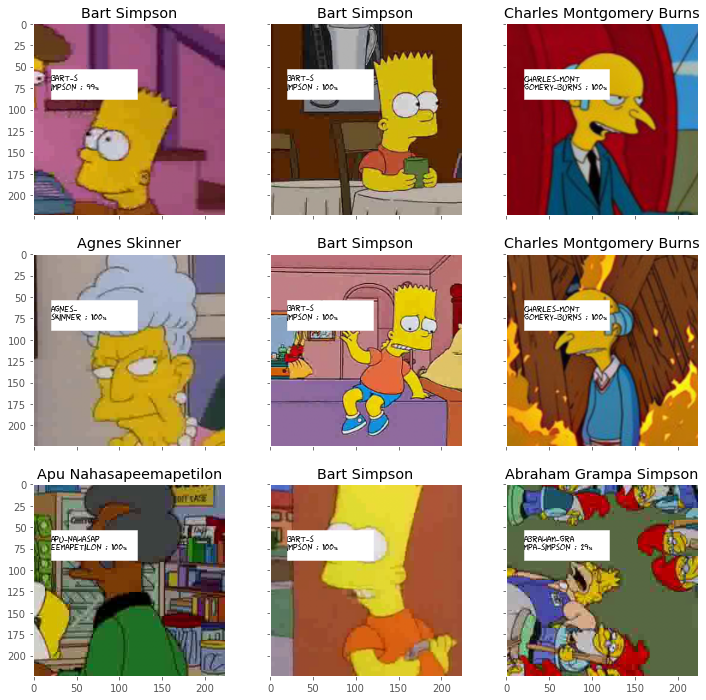

In [39]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((20, 53),100,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(ResNet50, im_val.unsqueeze(0))
    prob_pred = predict_one_sample(ResNet50, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = val_dataset.encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(20, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

# Выгружаем результаты на Kaggle.com

## `Название команды на Kaggle.com: Кирилл_Власенков_309815415`

## `Финальный скор: 0.98087`


In [40]:
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

probs = predict(ResNet50, test_dataloader)
preds = train_dataset.inverse_transform(torch.argmax(torch.from_numpy(probs), 1))
test_filenames = [path.name for path in test_dataset.files]

In [41]:
submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [42]:
 submit.to_csv('simpsons_submit.csv', index=False)